# Deep<span style="color:green">|</span>Bayes summer school. Practical session on EM algorithm

One of the school organisers decided to prank us and hid all games for our Thursday Game Night somewhere.

Let's find the prankster!

When you recognize [him or her](http://deepbayes.ru/#speakers), send:
* name
* reconstructed photo
* this notebook with your code (doesn't matter how awful it is :)

__privately__ to [Nadia Chirkova](https://www.facebook.com/nadiinchi) at Facebook or to info@deepbayes.ru. The first three participants will receive a present. Do not make spoilers to other participants!

Please, note that you have only __one attempt__ to send a message!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
DATA_FILE = "data_em"
w = 73 # face_width

### Data

We are given a set of $K$ images with shape $H \times W$.

It is represented by a numpy-array with shape $H \times W \times K$:

In [3]:
X = np.load(DATA_FILE)

In [4]:
X.shape # H, W, K

(100, 200, 1000)

Example of noisy image:

(-0.5, 199.5, 99.5, -0.5)

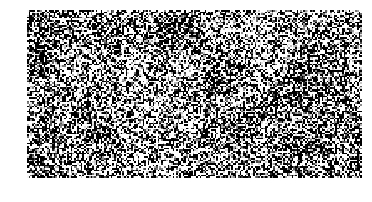

In [39]:
plt.imshow(X[:, :, 13], cmap="Greys_r")
plt.axis("off")

### Goal and plan

Our goal is to find face $F$ ($H \times w$).

Also, we will find:
* $B$: background  ($H \times W$)
* $s$: noise standard deviation (float)
* $a$: discrete prior over face positions ($W-w+1$)
* $q(d)$: discrete posterior over face positions for each image  (($W-w+1$) x $K$)

Implementation plan:
1. calculating $log\, p(X  \mid d,\,F,\,B,\,s)$
1. calculating objective
1. E-step: finding $q(d)$
1. M-step: estimating $F,\, B, \,s, \,a$
1. composing EM-algorithm from E- and M-step


### Implementation

In [6]:
### Variables to test implementation
tH, tW, tw, tK = 2, 3, 1, 2
tX = np.arange(tH*tW*tK).reshape(tH, tW, tK)
tF = np.arange(tH*tw).reshape(tH, tw)
tB = np.arange(tH*tW).reshape(tH, tW)
ts = 0.1
ta = np.arange(1, (tW-tw+1)+1)
ta = ta / ta.sum()
tq = np.arange(1, (tW-tw+1)*tK+1).reshape(tW-tw+1, tK)
tq = tq / tq.sum(axis=0)[np.newaxis, :]

#### 1. Implement calculate_log_probability
For $k$-th image $X_k$ and some face position $d_k$:
$$p(X_k  \mid d_k,\,F,\,B,\,s) = \prod_{ij}
    \begin{cases} 
    	\mathcal{N}(X_k[i,j]\mid F[i,\,j-d_k],\,s^2), 
    	& \text{if}\, (i,j)\in faceArea(d_k)\\
    	\mathcal{N}(X_k[i,j]\mid B[i,j],\,s^2), & \text{else}
    \end{cases}$$

Important notes:
* Do not forget about logarithm!
* This implementation should use no more than 1 cycle!

In [7]:
def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k, F, B, s) for all images X_k in X and
    all possible face position d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(W-w+1, K)
        ll[dw, k] - log-likelihood of observing image X_k given
        that the prankster's face F is located at position dw
    """
    # your code here
    def log_normal(x, mu, sigma):
        # x: [H, w, K]
        # mu: [H, w]
        # sigma: [1]
        
        return -0.5*np.sum(np.log(2*np.pi*sigma**2)+(x - mu[:,:,None])**2/sigma**2, axis=(0,1))
        
    H, W, K = X.shape # H, W, K
    w = F.shape[1]
    ll = np.zeros((W-w+1, K))
    for dw in range(W-w+1):
        ll[dw] = log_normal(X[:,dw:dw+w], F, s)
        if dw > 0:
            ll[dw] += log_normal(X[:,:dw], B[:,:dw], s)
        if dw+w < W:
            ll[dw] += log_normal(X[:,dw+w:], B[:,dw+w:], s)
    return ll
        

In [8]:
# run this cell to test your implementation
expected = np.array([[-3541.69812064, -5541.69812064],
       [-4541.69812064, -6741.69812064],
       [-6141.69812064, -8541.69812064]])
actual = calculate_log_probability(tX, tF, tB, ts)
print(actual)
assert np.allclose(actual, expected)
print("OK")

[[-3541.69812064 -5541.69812064]
 [-4541.69812064 -6741.69812064]
 [-6141.69812064 -8541.69812064]]
OK


#### 2. Implement calculate_lower_bound
$$\mathcal{L}(q, \,F, \,B,\, s,\, a) = \sum_k \biggl (\mathbb{E} _ {q( d_k)}\bigl ( \log p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s) + 
    \log p( d_k  \mid a)\bigr) - \mathbb{E} _ {q( d_k)} \log q( d_k)\biggr) $$
    
Important notes:
* Use already implemented calculate_log_probability! 
* Note that distributions $q( d_k)$ and $p( d_k  \mid a)$ are discrete. For example, $P(d_k=i \mid a) = a[i]$.
* This implementation should not use cycles!

In [88]:
def hard_q(q):
    # q: (W-w+1, K)
    q_hard = np.zeros_like(q)
    idx = np.argmax(q, axis=0)
    q_hard[idx, :] = 1.
    return q_hard

def calculate_lower_bound(X, F, B, s, a, q, hard_EM=False):
    """
    Calculates the lower bound L(q, F, B, s, a) for 
    the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    q : array, shape(W-w+1, K)
        q[dw, k] - estimate of posterior 
                   of position dw
                   of prankster's face given image Xk

    Returns
    -------
    L : float
        The lower bound L(q, F, B, s, a) 
        for the marginal log likelihood.
    """
    # your code here
    ll = calculate_log_probability(X, F, B, s) # (W-w+1, K)
    if not hard_EM:
        L = np.sum(q * (ll + np.log(a[:,None]) - np.log(q+1e-10)))
    else:
        q_idx = np.argmax(q, axis=0)
        L = np.sum(ll[q_idx,:] + np.log(a[q_idx,None]))
    return L

In [89]:
# run this cell to test your implementation
expected = -12761.1875
actual = calculate_lower_bound(tX, tF, tB, ts, ta, tq)
print(actual)
assert np.allclose(actual, expected)
print("OK")

-12761.187501002034
OK


#### 3. Implement E-step
$$q(d_k) = p(d_k \mid X_k, \,F, \,B, \,s,\, a) = 
\frac {p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s)\, p(d_k \mid a)}
{\sum_{d'_k} p(  X_{k}  \mid d'_k , \,F,\,B,\,s) \,p(d'_k \mid a)}$$

Important notes:
* Use already implemented calculate_log_probability!
* For computational stability, perform all computations with logarithmic values and apply exp only before return. Also, we recommend using this trick:
$$\beta_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\beta_i}}{\sum_k e^{\beta_k}} = 
	\frac{e^{(\beta_i - \max_j \beta_j)}}{\sum_k e^{(\beta_k- \max_j \beta_j)}}$$
* This implementation should not use cycles!

In [87]:
def run_e_step(X, F, B, s, a, hard_EM=True):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k, F, B, s, a).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(H, w)
        Estimate of prankster's face.
    B : array shape(H, W)
        Estimate of background.
    s : float
        Eestimate of standard deviation of Gaussian noise.
    a : array, shape(W-w+1)
        Estimate of prior on face position in any image.

    Returns
    -------
    q : array
        shape (W-w+1, K)
        q[dw, k] - estimate of posterior of position dw
        of prankster's face given image Xk
    """
    # your code here
    log_p = calculate_log_probability(X, F, B, s) # (W-w+1, K)
    log_joint = log_p + np.log(a[:, None]) # (W-w+1, K)
    log_max = np.max(log_joint, axis=0, keepdims=True) # (W-w+1, 1)
    numerator = np.exp(log_joint - log_max) # (W-w+1, K)
    denominator = np.sum(numerator, axis=0, keepdims=True) # (W-w+1, 1)
    q = numerator / denominator
    return q

In [84]:
# run this cell to test your implementation
expected = np.array([[ 1.,  1.],
                   [ 0.,  0.],
                   [ 0.,  0.]])
actual = run_e_step(tX, tF, tB, ts, ta)
print(actual)
assert np.allclose(actual, expected)
print("OK")

[[1. 1.]
 [0. 0.]
 [0. 0.]]
OK


#### 4. Implement M-step
$$a[j] = \frac{\sum_k q( d_k = j )}{\sum_{j'}  \sum_{k'} q( d_{k'} = j')}$$
$$F[i, m] = \frac 1 K  \sum_k \sum_{d_k} q(d_k)\, X^k[i,\, m+d_k]$$
$$B[i, j] = \frac {\sum_k \sum_{ d_k:\, (i, \,j) \,\not\in faceArea(d_k)} q(d_k)\, X^k[i, j]} 
	  	{\sum_k \sum_{d_k: \,(i, \,j)\, \not\in faceArea(d_k)} q(d_k)}$$
$$s^2 = \frac 1 {HWK}   \sum_k \sum_{d_k} q(d_k)
	  	\sum_{i,\, j}  (X^k[i, \,j] - Model^{d_k}[i, \,j])^2$$

where $Model^{d_k}[i, j]$ is an image composed from background and face located at $d_k$.

Important notes:
* Update parameters in the following order: $a$, $F$, $B$, $s$.
* When the parameter is updated, its __new__ value is used to update other parameters.
* This implementation should use no more than 3 cycles and no embedded cycles!

In [90]:
def run_m_step(X, q, w, hard_EM=True):
    """
    Estimates F, B, s, a given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    q  : array, shape (W-w+1, K)
        q[dw, k] - estimate of posterior of position dw
                   of prankster's face given image Xk
    w : int
        Face mask width.

    Returns
    -------
    F : array, shape (H, w)
        Estimate of prankster's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    """
    # your code here
    H, W, K = X.shape
    # update a
    a = np.sum(q, axis=1) / np.sum(q)
    # update F
    F = 0.
    for dw in range(W-w+1):
        F += np.sum(q[dw,:] * X[:, dw:dw+w], axis=2)
    F /= K
    # update B
    B = np.zeros((H, W))
    Z = np.zeros((H, W))
    for dw in range(W-w+1):
        if dw > 0:
            B[:, :dw] += np.sum(q[dw, :] * X[:, :dw], axis=2)
            Z[:, :dw] += np.sum(q[dw, :])
        if dw + w < W:
            B[:, dw+w:] += np.sum(q[dw, :] * X[:, dw+w:], axis=2)
            Z[:, dw+w:] += np.sum(q[dw, :])
    B /= Z
    # update s
    s_2 = 0.
    for dw in range(W-w+1):
        model = B.copy()
        model[:,dw:dw+w] = F
        s_2 += np.sum(q[dw, :] * np.sum((X - model[:,:,None])**2, axis=(0,1)))
        
    s = np.sqrt(s_2 / H / W / K)
                
    return F, B, s, a
    

In [91]:
# run this cell to test your implementation
expected = [np.array([[ 3.27777778],
                      [ 9.27777778]]),
 np.array([[  0.48387097,   2.5       ,   4.52941176],
           [  6.48387097,   8.5       ,  10.52941176]]),
  0.94868,
 np.array([ 0.13888889,  0.33333333,  0.52777778])]
actual = run_m_step(tX, tq, tw)
print(actual)
for a, e in zip(actual, expected):
    assert np.allclose(a, e)
print("OK")

(array([[3.27777778],
       [9.27777778]]), array([[ 0.48387097,  2.5       ,  4.52941176],
       [ 6.48387097,  8.5       , 10.52941176]]), 0.9486806229147358, array([0.13888889, 0.33333333, 0.52777778]))
OK


#### 5. Implement EM_algorithm
Initialize parameters, if they are not passed, and then repeat E- and M-steps till convergence.

Please note that $\mathcal{L}(q, \,F, \,B, \,s, \,a)$ must increase after each iteration.

In [59]:
def run_EM(X, w, F=None, B=None, s=None, a=None, tolerance=0.001,
           max_iter=50):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    w : int
        Face mask width.
    F : array, shape (H, w), optional
        Initial estimate of prankster's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    a : array, shape (W-w+1), optional
        Initial estimate of prior on position of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.

    Returns
    -------
    F, B, s, a : trained parameters.
    LL : array, shape(number_of_iters + 2,)
        L(q, F, B, s, a) at initial guess, 
        after each EM iteration and after
        final estimate of posteriors;
        number_of_iters is actual number of iterations that was done.
    """
    H, W, N = X.shape
    if F is None:
        F = np.random.randint(0, 255, (H, w))
    if B is None:
        B = np.random.randint(0, 255, (H, W))
    if a is None:
        a = np.ones(W - w + 1)
        a /= np.sum(a)
    if s is None:
        s = np.random.rand()*pow(64,2)
    # your code here
    LL = []
    number_of_iters = 0
    L = calculate_lower_bound(X, F, B, s, a, run_e_step(X, F, B, s, a))
    LL.append(L)
    while True:
        q = run_e_step(X, F, B, s, a)
        F, B, s, a = run_m_step(X, q, w)
        L = calculate_lower_bound(X, F, B, s, a, q)
        print('ELBO: {:.4f}'.format(L))
        LL.append(L)
        number_of_iters += 1
        if number_of_iters > max_iter or np.abs(L - LL[-2]) < tolerance:
            break
    return F, B, s, a, np.array(LL)

In [60]:
# run this cell to test your implementation
res = run_EM(tX, tw, max_iter=3)
LL = res[-1]
assert np.alltrue(LL[1:] - LL[:-1] > 0)
print("OK")

ELBO: -17.8127
ELBO: -11.0014
ELBO: -8.7158
ELBO: -8.7095
OK


### Who is the prankster?

To speed up the computation, we will perform 5 iterations over small subset of images and then gradually increase the subset.

If everything is implemented correctly, you will recognize the prankster (remember he is the one from [DeepBayes team](http://deepbayes.ru/#speakers)).

Run EM-algorithm:

In [32]:
def show(F, i=1, n=1):
    """
    shows face F at subplot i out of n
    """
    plt.subplot(1, n, i)
    plt.imshow(F, cmap="Greys_r")
    plt.axis("off")

ELBO: -6163252.5422
ELBO: -6154669.4706
ELBO: -6152311.1027
ELBO: -6152225.4006
ELBO: -6152225.4006
ELBO: -12316476.4626
ELBO: -12314129.7808
ELBO: -36967505.1034
ELBO: -36965873.3982
ELBO: -61618138.1289
ELBO: -61617283.1342
ELBO: -123247558.3703
ELBO: -123246965.1503


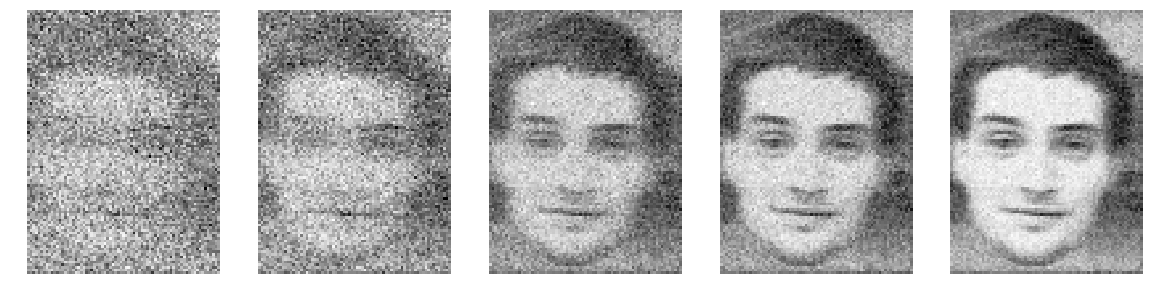

In [61]:
F, B, s, a = [None] * 4
LL = []
lens = [50, 100, 300, 500, 1000]
iters = [5, 1, 1, 1, 1]
plt.figure(figsize=(20, 5))
for i, (l, it) in enumerate(zip(lens, iters)):
    F, B, s, a, _ = run_EM(X[:, :, :l], w, F, B, s, a, max_iter=it)
    show(F, i+1, 5)

And this is the background:

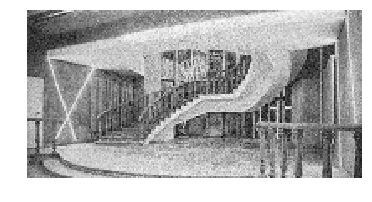

In [62]:
show(B)

### Optional part: hard-EM

If you have some time left, you can implement simplified version of EM-algorithm called hard-EM. In hard-EM, instead of finding posterior distribution $p(d_k|X_k, F, B, s, A)$ at E-step, we just remember its argmax $\tilde d_k$ for each image $k$. Thus, the distribution q is replaced with a singular distribution:
$$q(d_k) = \begin{cases} 1, \, if d_k = \tilde d_k \\ 0, \, otherwise\end{cases}$$
This modification simplifies formulas for $\mathcal{L}$ and M-step and speeds their computation up. However, the convergence of hard-EM is usually slow.

If you implement hard-EM, add binary flag hard_EM to the parameters of the following functions:
* calculate_lower_bound
* run_e_step
* run_m_step
* run_EM

After implementation, compare overall computation time for EM and hard-EM till recognizable F.